# Full Capstone Project

## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, ConvLSTM2D, concatenate, Dropout, BatchNormalization, Embedding, Reshape, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, Callback
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pretty_midi
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

### Set Random Seeds

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Load MIDI Data & Create Sequences

We want to use the Cymatics dataset, which has 424 midi files. Each file has some chord progression played for 8 or 16 seconds, along with a top melody.

There are 128 possible notes. At 8 frames per second, we account for each 1/16th note in the sequence. This should capture all the data effectively, as the melodies don't have anything less than 1/16th notes.

In [61]:
def load_midi_files(folder_path):
    """Load all MIDI files from the given folder."""
    midi_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.mid') or file.endswith('.midi'):
                file_path = os.path.join(root, file)
                midi_files.append(file_path)
    return midi_files

def midi_to_piano_roll(midi_file, fs=8):
    """Convert a MIDI file to a transposed and binarized piano roll representation."""
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        piano_roll = midi_data.get_piano_roll(fs=fs)
        piano_roll = (piano_roll.T > 0).astype(int)
        return piano_roll
    except Exception as e:
        print(f"Error reading {midi_file}: {e}")
        return None
    
    return piano_roll

def create_sequences(piano_roll, input_length=48, output_length=16, fs=8):
    """Create input-output sequences from a piano roll."""
    if piano_roll is None:
        return []

    total_length = input_length + output_length
    sequences = []

    num_steps = piano_roll.shape[0] // total_length
    for i in range(num_steps):
        start = i * total_length
        end_input = start + input_length
        end_output = end_input + output_length

        input_seq = piano_roll[start:end_input, :]
        output_seq = piano_roll[end_input:end_output, :]

        if input_seq.shape[0] == input_length and output_seq.shape[0] == output_length:
            sequences.append((input_seq, output_seq))

    return sequences

def process_folder(folder_path, fs=8, input_length=48, output_length=16):
    """Process all MIDI files in a folder and create input-output sequences."""
    midi_files = load_midi_files(folder_path)
    all_sequences = []

    for midi_file in midi_files:
        piano_roll = midi_to_piano_roll(midi_file, fs=fs)
        sequences = create_sequences(piano_roll, input_length=input_length, output_length=output_length, fs=fs)
        all_sequences.extend(sequences)

    return all_sequences

folder_path = 'cymatics-midi'
sequences = process_folder(folder_path)

print(f"Total sequences created: {len(sequences)}")


Error reading cymatics-midi/Cymatics - Essential MIDI 26 - F Min - Vol 7.mid: MIDI file has a largest tick of 4294968753, it is likely corrupt
Total sequences created: 663


## Split Sequences and Trim for 4 and 2 seconds

In [62]:
def split_sequences(sequences, train_ratio=0.7, val_ratio=0.15):
    """Split sequences into train, validation, and test sets."""
    np.random.shuffle(sequences)
    np.random.seed(42)
    
    total_len = len(sequences)
    train_end = int(train_ratio * total_len)
    val_end = train_end + int(val_ratio * total_len)

    train_sequences = sequences[:train_end]
    val_sequences = sequences[train_end:val_end]
    test_sequences = sequences[val_end:]

    return train_sequences, val_sequences, test_sequences

def save_sequences_to_pkl(sequences, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(sequences, f)

train_sequences, val_sequences, test_sequences = split_sequences(sequences)

print(len(train_sequences))
print(len(val_sequences))
print(len(test_sequences))

save_sequences_to_pkl(train_sequences, '62sec_train_sequences.pkl')
save_sequences_to_pkl(val_sequences, '62sec_val_sequences.pkl')
save_sequences_to_pkl(test_sequences, '62sec_test_sequences.pkl')

464
99
100


In [9]:
def trim_sequences(sequences, new_input_length, output_length=16):
    """Trim sequences to new input lengths."""
    new_sequences = []

    for input_seq, output_seq in sequences:
        if input_seq.shape[0] >= new_input_length:
            trimmed_input_seq = input_seq[-new_input_length:, :]
            new_sequences.append((trimmed_input_seq, output_seq))

    return new_sequences


def save_trimmed_splits(train_sequences, val_sequences, test_sequences, input_length, output_length, prefix):
    train_sequences_trimmed = trim_sequences(train_sequences, new_input_length=input_length, output_length=output_length)
    val_sequences_trimmed = trim_sequences(val_sequences, new_input_length=input_length, output_length=output_length)
    test_sequences_trimmed = trim_sequences(test_sequences, new_input_length=input_length, output_length=output_length)
    
    with open(f'{prefix}_train_sequences.pkl', 'wb') as f:
        pickle.dump(train_sequences_trimmed, f)
    with open(f'{prefix}_val_sequences.pkl', 'wb') as f:
        pickle.dump(val_sequences_trimmed, f)
    with open(f'{prefix}_test_sequences.pkl', 'wb') as f:
        pickle.dump(test_sequences_trimmed, f)

# Create and save new splits with 4 seconds input, 2 seconds output
input_length_4sec = 32  # 4 seconds * 8 FS
save_trimmed_splits(train_sequences, val_sequences, test_sequences, input_length=input_length_4sec, output_length=16, prefix='42sec')

# Create and save new splits with 2 seconds input, 2 seconds output
input_length_2sec = 16  # 2 seconds * 8 FS
save_trimmed_splits(train_sequences, val_sequences, test_sequences, input_length=input_length_2sec, output_length=16, prefix='22sec')

## Prepare Data

In [3]:
# Restore Removed Notes after model has been trained and saved
def restore_removed_notes(predicted_sequences, played_notes, total_notes=128):
    restored_sequences = []
    for sequence in predicted_sequences:
        restored_sequence = np.zeros((sequence.shape[0], total_notes))
        restored_sequence[:, played_notes] = sequence
        restored_sequences.append(restored_sequence)
    return restored_sequences

# Generate predictions
# predictions = model.predict([test_data_prepared[0], test_data_prepared[1]])

# Restore removed notes in the predictions
# predictions_restored = restore_removed_notes(predictions, played_notes)

# After this, we can access elements from predictions_restored to generate MIDI

In [4]:
def identify_played_notes(dataset):
    played_notes = set()
    for sequence in dataset:
        input_seq, output_seq = sequence
        # Add notes that are played in input and output sequences
        played_notes.update(np.where(input_seq.any(axis=0))[0])
        played_notes.update(np.where(output_seq.any(axis=0))[0])
    return played_notes

# Function to filter dataset using the comprehensive set of played notes
def filter_dataset(dataset, played_notes):
    filtered_dataset = []
    for sequence in dataset:
        input_seq, output_seq = sequence
        # Keep only the columns corresponding to played notes
        input_seq_filtered = input_seq[:, played_notes]
        output_seq_filtered = output_seq[:, played_notes]
        filtered_dataset.append((input_seq_filtered, output_seq_filtered))
    return filtered_dataset

In [5]:
# Function to import .pkl files
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Function to prepare data for encoder-decoder model
def prepare_data(data):
    encoder_input_data = np.array([item[0] for item in data])
    decoder_target_data = np.array([item[1] for item in data])
    
    # Prepare decoder input data
    decoder_input_data = np.zeros_like(decoder_target_data)
    decoder_input_data[:, 1:, :] = decoder_target_data[:, :-1, :]
    
    return encoder_input_data, decoder_input_data, decoder_target_data

In [6]:
def load_and_prepare_all_sequences():
    # Define the sequence lengths and file paths
    sequence_lengths = [62, 42, 22]
    datasets = [
        ('Splits/62sec_train_sequences.pkl', 'Splits/62sec_val_sequences.pkl', 'Splits/62sec_test_sequences.pkl'),
        ('Splits/42sec_train_sequences.pkl', 'Splits/42sec_val_sequences.pkl', 'Splits/42sec_test_sequences.pkl'),
        ('Splits/22sec_train_sequences.pkl', 'Splits/22sec_val_sequences.pkl', 'Splits/22sec_test_sequences.pkl')
    ]
    
    # Step 1: Identify the largest set of played notes across all datasets
    all_played_notes = set()
    
    for _, (train_path, val_path, test_path) in zip(sequence_lengths, datasets):
        # Load the data
        train_data = load_data(train_path)
        val_data = load_data(val_path)
        test_data = load_data(test_path)
        
        # Identify played notes in each dataset
        all_played_notes.update(identify_played_notes(train_data))
        all_played_notes.update(identify_played_notes(val_data))
        all_played_notes.update(identify_played_notes(test_data))
    
    # Convert played_notes to a sorted list for consistent indexing
    all_played_notes = sorted(list(all_played_notes))
    
    # Step 2: Filter and prepare each dataset
    all_data = {}
    
    for seq_len, (train_path, val_path, test_path) in zip(sequence_lengths, datasets):
        # Load the data
        train_data = load_data(train_path)
        val_data = load_data(val_path)
        test_data = load_data(test_path)
        
        # Filter the datasets using the comprehensive set of played notes
        train_data_filtered = filter_dataset(train_data, all_played_notes)
        val_data_filtered = filter_dataset(val_data, all_played_notes)
        test_data_filtered = filter_dataset(test_data, all_played_notes)
        
        # Prepare the data
        encoder_input_data_train, decoder_input_data_train, decoder_target_data_train = prepare_data(train_data_filtered)
        encoder_input_data_val, decoder_input_data_val, decoder_target_data_val = prepare_data(val_data_filtered)
        encoder_input_data_test, decoder_input_data_test, decoder_target_data_test = prepare_data(test_data_filtered)
        
        # Store the data in a dictionary
        all_data[seq_len] = {
            'encoder_input_data_train': encoder_input_data_train,
            'decoder_input_data_train': decoder_input_data_train,
            'decoder_target_data_train': decoder_target_data_train,
            'encoder_input_data_val': encoder_input_data_val,
            'decoder_input_data_val': decoder_input_data_val,
            'decoder_target_data_val': decoder_target_data_val,
            'encoder_input_data_test': encoder_input_data_test,
            'decoder_input_data_test': decoder_input_data_test,
            'decoder_target_data_test': decoder_target_data_test,
            'played_notes': all_played_notes
        }
    
    return all_data

all_data = load_and_prepare_all_sequences()

In [7]:
len(all_data[22]['played_notes'])

82

## EDA

In [18]:
# Function to analyze data shape and structure
def analyze_data_shape(data):
    for seq_len, data_dict in data.items():
        print(f"Sequence Length: {seq_len}")
        print(f"Train Encoder Input Shape: {data_dict['encoder_input_data_train'].shape}")
        print(f"Train Decoder Input Shape: {data_dict['decoder_input_data_train'].shape}")
        print(f"Train Decoder Target Shape: {data_dict['decoder_target_data_train'].shape}")
        print(f"Validation Encoder Input Shape: {data_dict['encoder_input_data_val'].shape}")
        print(f"Validation Decoder Input Shape: {data_dict['decoder_input_data_val'].shape}")
        print(f"Validation Decoder Target Shape: {data_dict['decoder_target_data_val'].shape}")
        print(f"Test Encoder Input Shape: {data_dict['encoder_input_data_test'].shape}")
        print(f"Test Decoder Input Shape: {data_dict['decoder_input_data_test'].shape}")
        print(f"Test Decoder Target Shape: {data_dict['decoder_target_data_test'].shape}")
        print("\n")

# Analyze data shape
analyze_data_shape(all_data)

Sequence Length: 62
Train Encoder Input Shape: (464, 48, 82)
Train Decoder Input Shape: (464, 16, 82)
Train Decoder Target Shape: (464, 16, 82)
Validation Encoder Input Shape: (99, 48, 82)
Validation Decoder Input Shape: (99, 16, 82)
Validation Decoder Target Shape: (99, 16, 82)
Test Encoder Input Shape: (100, 48, 82)
Test Decoder Input Shape: (100, 16, 82)
Test Decoder Target Shape: (100, 16, 82)


Sequence Length: 42
Train Encoder Input Shape: (464, 32, 82)
Train Decoder Input Shape: (464, 16, 82)
Train Decoder Target Shape: (464, 16, 82)
Validation Encoder Input Shape: (99, 32, 82)
Validation Decoder Input Shape: (99, 16, 82)
Validation Decoder Target Shape: (99, 16, 82)
Test Encoder Input Shape: (100, 32, 82)
Test Decoder Input Shape: (100, 16, 82)
Test Decoder Target Shape: (100, 16, 82)


Sequence Length: 22
Train Encoder Input Shape: (464, 16, 82)
Train Decoder Input Shape: (464, 16, 82)
Train Decoder Target Shape: (464, 16, 82)
Validation Encoder Input Shape: (99, 16, 82)
Valid

Sequence Length: 62
Sequence Length: 42
Sequence Length: 22


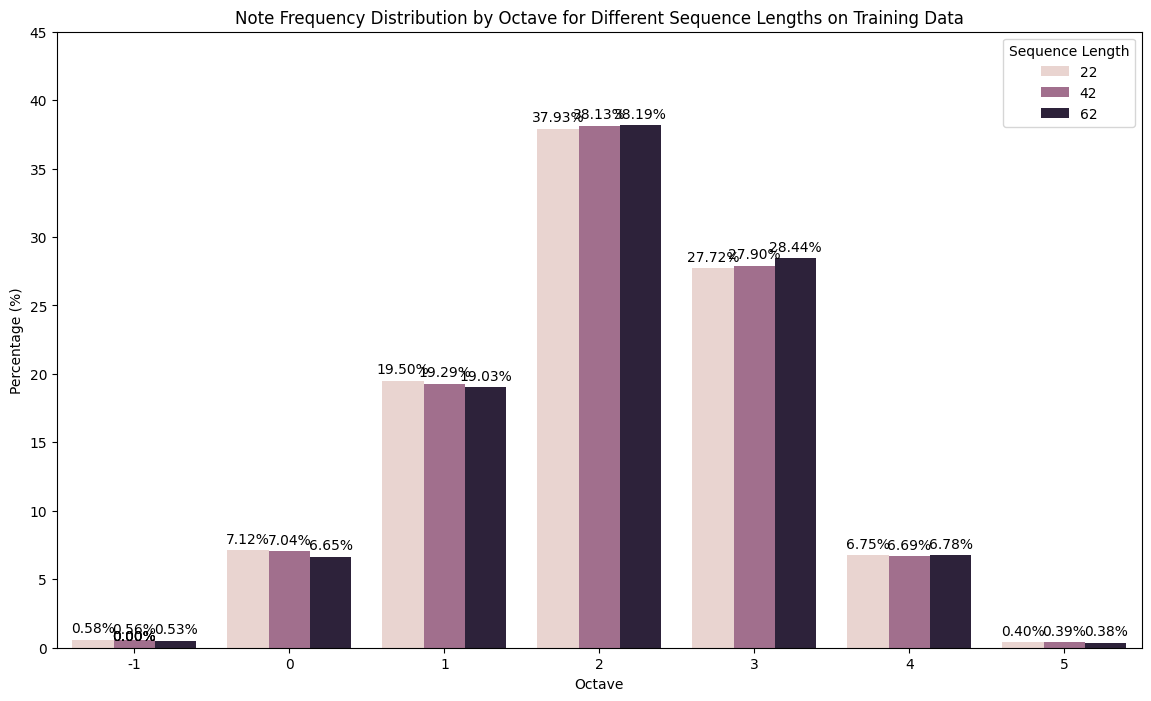

In [26]:
# Function to map MIDI note number to octave
def note_to_octave(note):
    return (note // 12) - 1

# Function to analyze note frequency by octave as percentages
def analyze_note_frequency_by_octave(data, y_limit):
    all_octave_data = []

    for seq_len, data_dict in data.items():
        print(f"Sequence Length: {seq_len}")
        
        # Sum the notes played across all timesteps and sequences separately for each dataset
        note_counts_encoder = np.sum(data_dict['encoder_input_data_train'], axis=(0, 1))
        note_counts_decoder_input = np.sum(data_dict['decoder_input_data_train'], axis=(0, 1))
        note_counts_decoder_target = np.sum(data_dict['decoder_target_data_train'], axis=(0, 1))
        
        # Combine note counts
        total_note_counts = note_counts_encoder + note_counts_decoder_input + note_counts_decoder_target
        
        # Calculate percentages
        total_notes = np.sum(total_note_counts)
        note_percentages = (total_note_counts / total_notes) * 100
        
        # Create a DataFrame with note and octave information
        octaves = [note_to_octave(i) for i in range(len(total_note_counts))]
        octave_df = pd.DataFrame({'Octave': octaves, 'Percentage': note_percentages, 'Sequence Length': seq_len})
        
        # Group by octave and sum the percentages
        octave_df_grouped = octave_df.groupby('Octave')['Percentage'].sum().reset_index()
        octave_df_grouped['Sequence Length'] = seq_len
        
        # Append to all_octave_data
        all_octave_data.append(octave_df_grouped)
    
    # Combine all data
    combined_data = pd.concat(all_octave_data)
    
    # Plot the combined octave distribution as percentages
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Octave', y='Percentage', hue='Sequence Length', data=combined_data)
    
    # Annotate bars with percentage values
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=10, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.title('Note Frequency Distribution by Octave for Different Sequence Lengths on Training Data')
    plt.xlabel('Octave')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, y_limit)  # Set y-axis limit to keep it consistent
    plt.legend(title='Sequence Length')
    plt.savefig('FrequencyDistributionbySeqLen_train')
    plt.show()

# Analyze note frequency by octave as percentages with a consistent y-axis limit
analyze_note_frequency_by_octave(all_data, 45)

Sequence Length: 62
Sequence Length: 42
Sequence Length: 22


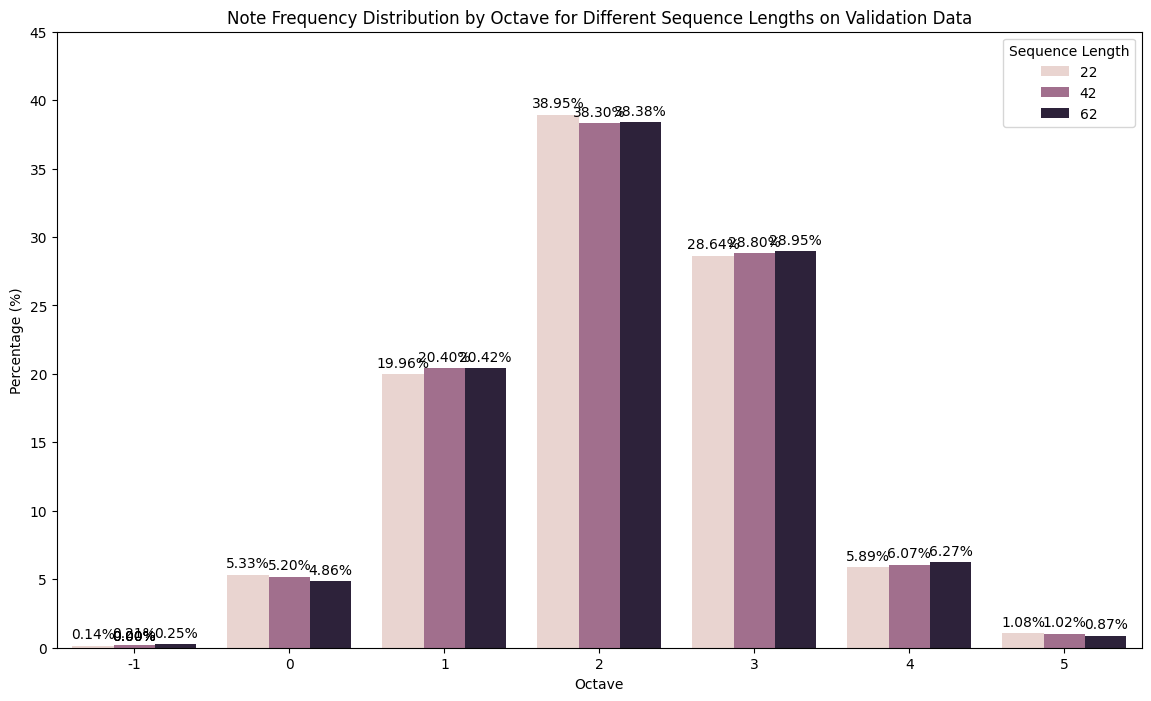

In [27]:
# Function to map MIDI note number to octave
def note_to_octave(note):
    return (note // 12) - 1

# Function to analyze note frequency by octave as percentages
def analyze_note_frequency_by_octave(data, y_limit):
    all_octave_data = []

    for seq_len, data_dict in data.items():
        print(f"Sequence Length: {seq_len}")
        
        # Sum the notes played across all timesteps and sequences separately for each dataset
        note_counts_encoder = np.sum(data_dict['encoder_input_data_val'], axis=(0, 1))
        note_counts_decoder_input = np.sum(data_dict['decoder_input_data_val'], axis=(0, 1))
        note_counts_decoder_target = np.sum(data_dict['decoder_target_data_val'], axis=(0, 1))
        
        # Combine note counts
        total_note_counts = note_counts_encoder + note_counts_decoder_input + note_counts_decoder_target
        
        # Calculate percentages
        total_notes = np.sum(total_note_counts)
        note_percentages = (total_note_counts / total_notes) * 100
        
        # Create a DataFrame with note and octave information
        octaves = [note_to_octave(i) for i in range(len(total_note_counts))]
        octave_df = pd.DataFrame({'Octave': octaves, 'Percentage': note_percentages, 'Sequence Length': seq_len})
        
        # Group by octave and sum the percentages
        octave_df_grouped = octave_df.groupby('Octave')['Percentage'].sum().reset_index()
        octave_df_grouped['Sequence Length'] = seq_len
        
        # Append to all_octave_data
        all_octave_data.append(octave_df_grouped)
    
    # Combine all data
    combined_data = pd.concat(all_octave_data)
    
    # Plot the combined octave distribution as percentages
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Octave', y='Percentage', hue='Sequence Length', data=combined_data)
    
    # Annotate bars with percentage values
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=10, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.title('Note Frequency Distribution by Octave for Different Sequence Lengths on Validation Data')
    plt.xlabel('Octave')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, y_limit)  # Set y-axis limit to keep it consistent
    plt.legend(title='Sequence Length')
    plt.savefig('FrequencyDistributionbySeqLen_validation')
    plt.show()

# Analyze note frequency by octave as percentages with a consistent y-axis limit
analyze_note_frequency_by_octave(all_data, 45)

Sequence Length: 62
Sequence Length: 42
Sequence Length: 22


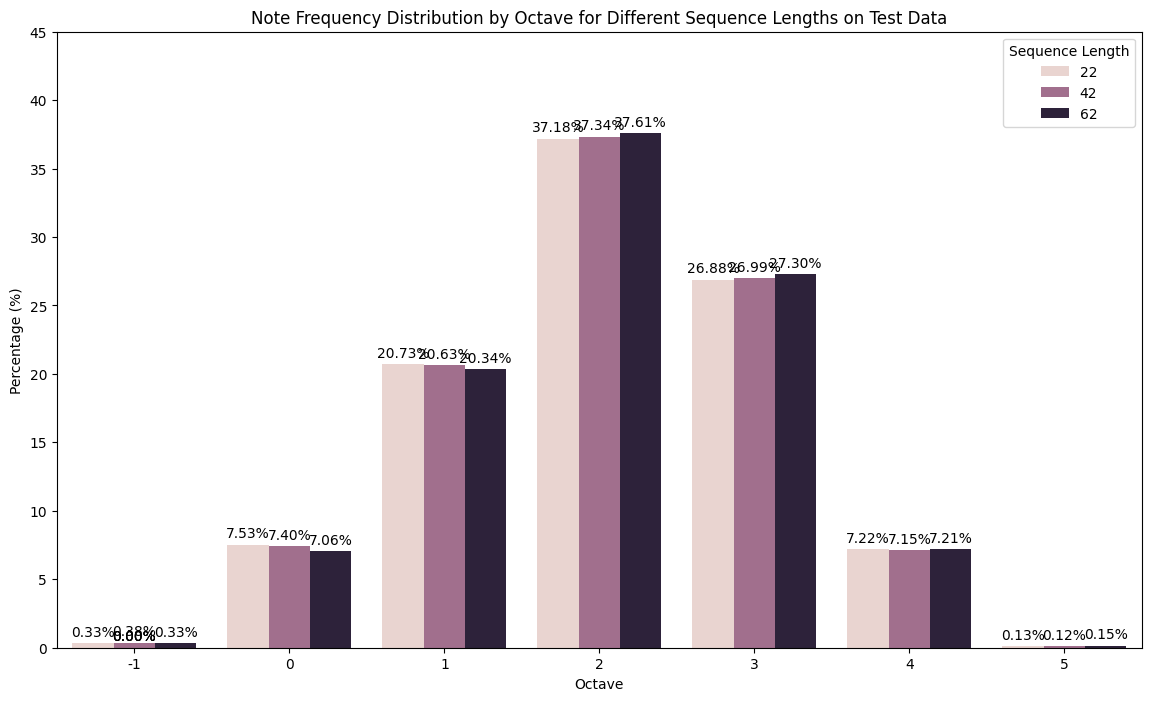

In [28]:
# Function to map MIDI note number to octave
def note_to_octave(note):
    return (note // 12) - 1

# Function to analyze note frequency by octave as percentages
def analyze_note_frequency_by_octave(data, y_limit):
    all_octave_data = []

    for seq_len, data_dict in data.items():
        print(f"Sequence Length: {seq_len}")
        
        # Sum the notes played across all timesteps and sequences separately for each dataset
        note_counts_encoder = np.sum(data_dict['encoder_input_data_test'], axis=(0, 1))
        note_counts_decoder_input = np.sum(data_dict['decoder_input_data_test'], axis=(0, 1))
        note_counts_decoder_target = np.sum(data_dict['decoder_target_data_test'], axis=(0, 1))
        
        # Combine note counts
        total_note_counts = note_counts_encoder + note_counts_decoder_input + note_counts_decoder_target
        
        # Calculate percentages
        total_notes = np.sum(total_note_counts)
        note_percentages = (total_note_counts / total_notes) * 100
        
        # Create a DataFrame with note and octave information
        octaves = [note_to_octave(i) for i in range(len(total_note_counts))]
        octave_df = pd.DataFrame({'Octave': octaves, 'Percentage': note_percentages, 'Sequence Length': seq_len})
        
        # Group by octave and sum the percentages
        octave_df_grouped = octave_df.groupby('Octave')['Percentage'].sum().reset_index()
        octave_df_grouped['Sequence Length'] = seq_len
        
        # Append to all_octave_data
        all_octave_data.append(octave_df_grouped)
    
    # Combine all data
    combined_data = pd.concat(all_octave_data)
    
    # Plot the combined octave distribution as percentages
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Octave', y='Percentage', hue='Sequence Length', data=combined_data)
    
    # Annotate bars with percentage values
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=10, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.title('Note Frequency Distribution by Octave for Different Sequence Lengths on Test Data')
    plt.xlabel('Octave')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, y_limit)  # Set y-axis limit to keep it consistent
    plt.legend(title='Sequence Length')
    plt.savefig('FrequencyDistributionbySeqLen_test')
    plt.show()

# Analyze note frequency by octave as percentages with a consistent y-axis limit
analyze_note_frequency_by_octave(all_data, 45)

In [34]:
def compute_cosine_similarity(frequencies1, frequencies2):
    # Use only the notes that appear in at least one dataset
    mask = (frequencies1 + frequencies2) > 0
    frequencies1_non_zero = frequencies1[mask]
    frequencies2_non_zero = frequencies2[mask]

    cosine_sim = 1 - cosine(frequencies1_non_zero, frequencies2_non_zero)
    
    return cosine_sim

def compute_and_print_cosine_similarities(all_data):
    for seq_len, data_dict in all_data.items():
        # Combine all training data sequences (encoder input, decoder input, decoder target) along the feature axis
        all_train_sequences = np.concatenate([
            data_dict['encoder_input_data_train'],
            data_dict['decoder_input_data_train'],
            data_dict['decoder_target_data_train']
        ], axis=1)

        all_val_sequences = np.concatenate([
            data_dict['encoder_input_data_val'],
            data_dict['decoder_input_data_val'],
            data_dict['decoder_target_data_val']
        ], axis=1)

        all_test_sequences = np.concatenate([
            data_dict['encoder_input_data_test'],
            data_dict['decoder_input_data_test'],
            data_dict['decoder_target_data_test']
        ], axis=1)

        # Sum the notes played across all timesteps and sequences
        train_note_frequencies = np.sum(all_train_sequences, axis=(0, 1))
        val_note_frequencies = np.sum(all_val_sequences, axis=(0, 1))
        test_note_frequencies = np.sum(all_test_sequences, axis=(0, 1))

        # Compute cosine similarities
        train_val_cosine = compute_cosine_similarity(train_note_frequencies, val_note_frequencies)
        val_test_cosine = compute_cosine_similarity(val_note_frequencies, test_note_frequencies)
        train_test_cosine = compute_cosine_similarity(train_note_frequencies, test_note_frequencies)

        print(f"Sequence Length: {seq_len}")
        print(f"Train-Val Cosine Similarity: {train_val_cosine:.4f}")
        print(f"Val-Test Cosine Similarity: {val_test_cosine:.4f}")
        print(f"Train-Test Cosine Similarity: {train_test_cosine:.4f}")
        print()

# Assuming all_data is already loaded and prepared
compute_and_print_cosine_similarities(all_data)

Sequence Length: 62
Train-Val Cosine Similarity: 0.9811
Val-Test Cosine Similarity: 0.9718
Train-Test Cosine Similarity: 0.9883

Sequence Length: 42
Train-Val Cosine Similarity: 0.9752
Val-Test Cosine Similarity: 0.9651
Train-Test Cosine Similarity: 0.9852

Sequence Length: 22
Train-Val Cosine Similarity: 0.9626
Val-Test Cosine Similarity: 0.9443
Train-Test Cosine Similarity: 0.9809



## Build Baseline Models

In this section, I would like to build 2 baseline models that will be used for comparison with my final encoder-decoder model.

1. **Repeat model** - this model will simply repeat the previous 2 seconds from the sequence as the predicted output.
2. **Repeat model** - this model will simply repeat the first 2 seconds from the sequence as the predicted output.
3. **Repeat with noise**
4. **Feedforward Neural Network** - This model will be used to show a neural network's ability to predict without the recurrent layers.

### Repeat Model (Last 2 Seconds)

In [30]:
# Function to calculate precision and recall given true and predicted values
def calculate_precision_recall(y_true, y_pred, threshold=0.5):
    y_pred_thresholded = (y_pred >= threshold).astype(int)
    precision = precision_score(y_true.flatten(), y_pred_thresholded.flatten(), zero_division=1)
    recall = recall_score(y_true.flatten(), y_pred_thresholded.flatten(), zero_division=1)
    return precision, recall

# Function to calculate baseline precision and recall by repeating the last part of the input sequence
def baseline_repeat_input(encoder_input_data_test, decoder_target_data_test, threshold=0.5):
    y_pred = encoder_input_data_test[:, -decoder_target_data_test.shape[1]:, :]
    
    precisions, recalls = [], []
    for y_true, y_pred_single in zip(decoder_target_data_test, y_pred):
        precision, recall = calculate_precision_recall(y_true, y_pred_single, threshold)
        precisions.append(precision)
        recalls.append(recall)
    
    return np.mean(precisions), np.mean(recalls)

# Evaluate baseline for each sequence length in the dataset
for seq_len, data_dict in all_data.items():
    encoder_input_data_test = data_dict['encoder_input_data_test']
    decoder_target_data_test = data_dict['decoder_target_data_test']
    
    precision, recall = baseline_repeat_input(encoder_input_data_test, decoder_target_data_test)
    print(f"Baseline Precision for {seq_len} seconds: {precision:.4f}, Baseline Recall for {seq_len} seconds: {recall:.4f}")

Baseline Precision for 62 seconds: 0.3510, Baseline Recall for 62 seconds: 0.3510
Baseline Precision for 42 seconds: 0.3510, Baseline Recall for 42 seconds: 0.3510
Baseline Precision for 22 seconds: 0.3510, Baseline Recall for 22 seconds: 0.3510


### Repeat Model (First 2 Seconds)

In [31]:
# Function to calculate precision and recall given true and predicted values
def calculate_precision_recall(y_true, y_pred, threshold=0.5):
    y_pred_thresholded = (y_pred >= threshold).astype(int)
    precision = precision_score(y_true.flatten(), y_pred_thresholded.flatten(), zero_division=1)
    recall = recall_score(y_true.flatten(), y_pred_thresholded.flatten(), zero_division=1)
    return precision, recall

# Function to calculate baseline precision and recall by using the first part of the input sequence
def baseline_first_two_seconds(encoder_input_data_test, decoder_target_data_test, threshold=0.5):
    # Assume each second is represented by a certain number of timesteps. Adjust this number accordingly.
    timesteps_per_second = encoder_input_data_test.shape[1] // 6  # Example: 6 seconds of input data
    num_timesteps = 2 * timesteps_per_second  # First 2 seconds

    y_pred = encoder_input_data_test[:, :num_timesteps, :]

    precisions, recalls = [], []
    for y_true, y_pred_single in zip(decoder_target_data_test, y_pred):
        precision, recall = calculate_precision_recall(y_true, y_pred_single, threshold)
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

# Evaluate baseline for each sequence length in the dataset
for seq_len, data_dict in all_data.items():
    if seq_len != 62:  # Only apply to the 62-second sequence length
        continue

    encoder_input_data_test = data_dict['encoder_input_data_test']
    decoder_target_data_test = data_dict['decoder_target_data_test']

    precision, recall = baseline_first_two_seconds(encoder_input_data_test, decoder_target_data_test)
    print(f"Baseline Precision for first two seconds of {seq_len} seconds: {precision:.4f}, Baseline Recall for first two seconds of {seq_len} seconds: {recall:.4f}")

    f1 = 2 * precision * recall / (precision + recall)
    print(f1)

Baseline Precision for first two seconds of 62 seconds: 0.2504, Baseline Recall for first two seconds of 62 seconds: 0.2459
0.2481130136159003


### Repeat with noise (Last 2 Seconds)

In [42]:
def calculate_precision_recall(y_true, y_pred, threshold=0.5):
    y_pred_thresholded = (y_pred >= threshold).astype(int)
    precision = precision_score(y_true.flatten(), y_pred_thresholded.flatten(), zero_division=1)
    recall = recall_score(y_true.flatten(), y_pred_thresholded.flatten(), zero_division=1)
    return precision, recall

# Function to calculate baseline precision and recall by repeating the last part of the input sequence
def baseline_repeat_input_with_noise(encoder_input_data_test, decoder_target_data_test, noise_level=0.1, threshold=0.5):
    y_pred = encoder_input_data_test[:, -decoder_target_data_test.shape[1]:, :]
    
    precisions, recalls = [], []
    for y_true, y_pred_single in zip(decoder_target_data_test, y_pred):
        # Add Gaussian noise to the prediction
        noisy_pred = y_pred_single + np.random.normal(0, noise_level, y_pred_single.shape)
        precision, recall = calculate_precision_recall(y_true, noisy_pred, threshold)
        precisions.append(precision)
        recalls.append(recall)
    
    return np.mean(precisions), np.mean(recalls)

# Evaluate baseline with noise for each sequence length in the dataset
noise_level = 0.3  # Adjust the noise level as needed
for seq_len, data_dict in all_data.items():
    encoder_input_data_test = data_dict['encoder_input_data_test']
    decoder_target_data_test = data_dict['decoder_target_data_test']
    
    precision, recall = baseline_repeat_input_with_noise(encoder_input_data_test, decoder_target_data_test, noise_level=noise_level)
    print(f"Baseline with Noise (Level={noise_level}) Precision for {seq_len} seconds: {precision:.4f}, Baseline Recall for {seq_len} seconds: {recall:.4f}")

Baseline with Noise (Level=0.3) Precision for 62 seconds: 0.1852, Baseline Recall for 62 seconds: 0.3652
Baseline with Noise (Level=0.3) Precision for 42 seconds: 0.1880, Baseline Recall for 42 seconds: 0.3686
Baseline with Noise (Level=0.3) Precision for 22 seconds: 0.1868, Baseline Recall for 22 seconds: 0.3672


### Feedforward Neural Network

In [9]:
# Function to build the feedforward neural network model
def build_ffnn_model(input_dim, output_dim, layers=3, units=2048, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(units, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    for _ in range(layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])
    return model

def train_ffnn_model(model, train_data, val_data, epochs=200, batch_size=32, model_name='model'):
    input_data_train, target_data_train = train_data
    input_data_val, target_data_val = val_data
    
    checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    csv_logger = CSVLogger(f'{model_name}_log.csv', append=True, separator=',')
    
    history = model.fit(
        input_data_train, target_data_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(input_data_val, target_data_val),
        callbacks=[checkpoint, early_stopping, csv_logger]
    )
    
    epochs_taken = len(history.history['loss'])
    
    return history, epochs_taken


def evaluate_ffnn_model(model, data):
    input_data, target_data = data
    results = model.evaluate(input_data, target_data)
    return results

In [ ]:
sequence_lengths = [62, 42, 22]
num_layers_list = [1, 2, 3]
dropout_rates = [0.3, 0.4, 0.5]
num_units_list = [256, 512, 1024, 2048]

# Initialize a list to store the results
all_results = []

for seq_len in sequence_lengths:
    for num_layers in num_layers_list:
        for num_units in num_units_list:
            for dropout_rate in dropout_rates:
                # Prepare data for FFNN
                train_data = (
                    all_data[seq_len]['encoder_input_data_train'].reshape((all_data[seq_len]['encoder_input_data_train'].shape[0], -1)),
                    all_data[seq_len]['decoder_target_data_train'].reshape((all_data[seq_len]['decoder_target_data_train'].shape[0], -1))
                )
                val_data = (
                    all_data[seq_len]['encoder_input_data_val'].reshape((all_data[seq_len]['encoder_input_data_val'].shape[0], -1)),
                    all_data[seq_len]['decoder_target_data_val'].reshape((all_data[seq_len]['decoder_target_data_val'].shape[0], -1))
                )
                test_data = (
                    all_data[seq_len]['encoder_input_data_test'].reshape((all_data[seq_len]['encoder_input_data_test'].shape[0], -1)),
                    all_data[seq_len]['decoder_target_data_test'].reshape((all_data[seq_len]['decoder_target_data_test'].shape[0], -1))
                )
                
                input_dim = train_data[0].shape[1]
                output_dim = train_data[1].shape[1]
                
                # Build FFNN model
                ffnn_model = build_ffnn_model(input_dim, output_dim, layers=num_layers, units=num_units, dropout_rate=dropout_rate)
                
                model_name = f'{seq_len}sec_{num_layers}layers_{num_units}units_{dropout_rate}drop'
                
                # Train FFNN model
                ffnn_history, epochs_taken = train_ffnn_model(ffnn_model, train_data, val_data, model_name=model_name)
                
                # Evaluate FFNN model
                train_results = evaluate_ffnn_model(ffnn_model, train_data)
                val_results = evaluate_ffnn_model(ffnn_model, val_data)
                test_results = evaluate_ffnn_model(ffnn_model, test_data)
                
                # Store results
                all_results.append({
                    'Model': model_name,
                    'Train_Loss': train_results[0],
                    'Train_Precision': train_results[1],
                    'Train_Recall': train_results[2],
                    'Val_Loss': val_results[0],
                    'Val_Precision': val_results[1],
                    'Val_Recall': val_results[2],
                    'Test_Precision': test_results[1],
                    'Test_Recall': test_results[2],
                    'Epochs_Taken': epochs_taken
                })

# Convert results to a DataFrame and save to a CSV file
results_df = pd.DataFrame(all_results)
results_df.to_csv('ffnn_results.csv', index=False)

# Print the results
print(results_df)

Epoch 1/200


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5949 - precision: 0.0493 - recall: 0.2708  
Epoch 1: val_loss improved from inf to 0.24873, saving model to 62sec_1layers_256units_0.3drop.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5780 - precision: 0.0492 - recall: 0.2529 - val_loss: 0.2487 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2607 - precision: 0.1172 - recall: 0.0013         
Epoch 2: val_loss improved from 0.24873 to 0.21105, saving model to 62sec_1layers_256units_0.3drop.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2572 - precision: 0.1344 - recall: 0.0024 - val_loss: 0.2110 - val_precision: 0.1429 - val_recall: 3.3151e-04
Epoch 3/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2159 - precision: 0.2276 - recall: 0.0142 
Epoch 3: val_loss improved from 0.21105 to 0.19856, saving model to 62sec_1layers_256units_0.3drop.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2149 - p

## Build Encoder Decoder Model

I would now like to build an encoder-decoder LSTM model that can be compared to the baseline model. Because one layer performed best for the feed-forward NN, I will focus on single layers for my LSTM, but with the same parameters

In [85]:
def build_simple_lstm_model(input_features, output_features, latent_dim, dropout_rate=0.5, optimizer_name='Adam', learning_rate=0.001):
    # Define encoder
    encoder_inputs = Input(shape=(None, input_features))
    encoder_lstm = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_outputs = BatchNormalization()(encoder_outputs)
    encoder_outputs = Dropout(dropout_rate)(encoder_outputs)
    
    encoder_states = [state_h, state_c]
    
    # Define decoder
    decoder_inputs = Input(shape=(None, output_features))
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = BatchNormalization()(decoder_outputs)
    decoder_outputs = Dropout(dropout_rate)(decoder_outputs)
    
    decoder_dense = TimeDistributed(Dense(output_features, activation='sigmoid'))
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # Compile the model
    optimizer = optimizers.get(optimizer_name)(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[Precision(), Recall()])

    return model


def train_lstm_model(model, train_data, val_data, model_name, epochs=200, batch_size=32):
    encoder_input_data_train, decoder_input_data_train, decoder_target_data_train = train_data
    encoder_input_data_val, decoder_input_data_val, decoder_target_data_val = val_data
    
    checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    csv_logger = CSVLogger(f'{model_name}_log.csv', append=True, separator=',')
    
    history = model.fit(
        [encoder_input_data_train, decoder_input_data_train], decoder_target_data_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=([encoder_input_data_val, decoder_input_data_val], decoder_target_data_val),
        callbacks=[checkpoint, early_stopping, csv_logger]
    )
    
    epochs_taken = len(history.history['loss'])
    
    return history, epochs_taken
    
def evaluate_lstm_model(model, data):
    encoder_input_data, decoder_input_data, decoder_target_data = data
    results = model.evaluate([encoder_input_data, decoder_input_data], decoder_target_data)
    return results


In [ ]:
units_list = [256]
dropout_rates = [0.6]
optimizers = {'Adam': Adam}
learning_rates = [0.001]
sequence_lengths = [62]
batch_sizes = [16]  # Added batch sizes to test

# Initialize a list to store the results incrementally
results_path = 'lstm_hyperparameter_tuning_results.csv'
with open(results_path, 'w') as f:
    f.write('Model,Input Sequence,Units,Dropout,Learning Rate,Batch Size,Epochs,Train_Loss,Train_Precision,Train_Recall,Val_Loss,Val_Precision,Val_Recall,Test_Precision,Test_Recall\n')

for seq_len in sequence_lengths:
    # Prepare data for LSTM
    train_data = (
        all_data[seq_len]['encoder_input_data_train'],
        all_data[seq_len]['decoder_input_data_train'],
        all_data[seq_len]['decoder_target_data_train']
    )
    val_data = (
        all_data[seq_len]['encoder_input_data_val'],
        all_data[seq_len]['decoder_input_data_val'],
        all_data[seq_len]['decoder_target_data_val']
    )
    test_data = (
        all_data[seq_len]['encoder_input_data_test'],
        all_data[seq_len]['decoder_input_data_test'],
        all_data[seq_len]['decoder_target_data_test']
    )
    
    input_features = train_data[0].shape[2]
    output_features = train_data[2].shape[2]
    
    for units in units_list:
        for dropout_rate in dropout_rates:
            for optimizer_name in optimizers.keys():
                for learning_rate in learning_rates:
                    for batch_size in batch_sizes:  # Added batch size loop
                        model_name = f'{seq_len}sec_1layer_{units}units_{dropout_rate}dropout_{optimizer_name}_lr{learning_rate}_batch{batch_size}'
                        
                        lstm_model = build_simple_lstm_model(input_features, output_features, latent_dim=units, dropout_rate=dropout_rate, optimizer_name=optimizer_name, learning_rate=learning_rate)
                        
                        lstm_history, epochs_taken = train_lstm_model(lstm_model, train_data, val_data, model_name, epochs=500, batch_size=batch_size)
                        
                        train_results = evaluate_lstm_model(lstm_model, train_data)
                        val_results = evaluate_lstm_model(lstm_model, val_data)
                        test_results = evaluate_lstm_model(lstm_model, test_data)
                        
                        # Append the results incrementally to the CSV file
                        with open(results_path, 'a') as f:
                            f.write(f'{model_name},{seq_len // 10},{units},{dropout_rate},{learning_rate},{batch_size},{epochs_taken},{train_results[0]},{train_results[1]},{train_results[2]},{val_results[0]},{val_results[1]},{val_results[2]},{test_results[1]},{test_results[2]}\n')
                        
                        # Clear session to free up memory
                        K.clear_session()

# Print the results
results_df = pd.read_csv(results_path)
print(results_df)

Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.9583 - precision_1: 0.0604 - recall_1: 0.6128
Epoch 1: val_loss improved from inf to 0.64952, saving model to 62sec_1layer_256units_0.6dropout_Adam_lr0.001_batch16.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.9563 - precision_1: 0.0608 - recall_1: 0.6159 - val_loss: 0.6495 - val_precision_1: 0.2981 - val_recall_1: 0.8183
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7586 - precision_1: 0.0961 - recall_1: 0.8742
Epoch 2: val_loss improved from 0.64952 to 0.57660, saving model to 62sec_1layer_256units_0.6dropout_Adam_lr0.001_batch16.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.7578 - precision_1: 0.0961 - recall_1: 0.8741 - val_loss: 0.5766 - val_precision_1: 0.7640 - val_recall_1: 0.6917
Epoch 3/500
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.6327 - precision_1: 0.1187 - recall_1: 0.8726
Epoch 3: val_loss improved from 0.57660 to 0.43319, saving model to 62sec_1layer_256units_0.6dro

## Results Analysis

In [39]:
# Analyze Results
file_path = 'lstm_hyperparameter_tuning_results.csv'
df = pd.read_csv(file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'lstm_hyperparameter_tuning_results.csv'

In [42]:
# Extract unique values for each hyperparameter
units_list = df['Units'].unique()
learning_rates = df['Learning Rate'].unique()
dropout_rates = df['Dropout'].unique()
batch_sizes = df['Batch Size'].unique()

In [43]:
import itertools

# Create a DataFrame with all possible combinations of hyperparameters
all_combinations = list(itertools.product(units_list, learning_rates, dropout_rates, batch_sizes))
columns = ['Units', 'Learning Rate', 'Dropout', 'Batch Size']
combinations_df = pd.DataFrame(all_combinations, columns=columns)

In [44]:
# Merge with the original DataFrame to ensure all combinations are represented
merged_df = pd.merge(combinations_df, df, on=columns, how='left')
merged_df.fillna(0, inplace=True)  # Fill missing values with zero

In [45]:
print(merged_df['F1 Score'].apply(type).value_counts())

F1 Score
<class 'float'>    144
Name: count, dtype: int64


In [46]:
# Convert 'Test_F1' column to numeric, coercing errors to NaN
merged_df['F1 Score'] = pd.to_numeric(merged_df['F1 Score'], errors='coerce')

# Fill NaN values with 0
merged_df['F1 Score'] = merged_df['F1 Score'].fillna(0)

In [47]:
merged_df['Units'] = pd.to_numeric(merged_df['Units'])
merged_df['Dropout'] = pd.to_numeric(merged_df['Dropout'])
merged_df['F1 Score'] = pd.to_numeric(merged_df['F1 Score'])

/opt/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


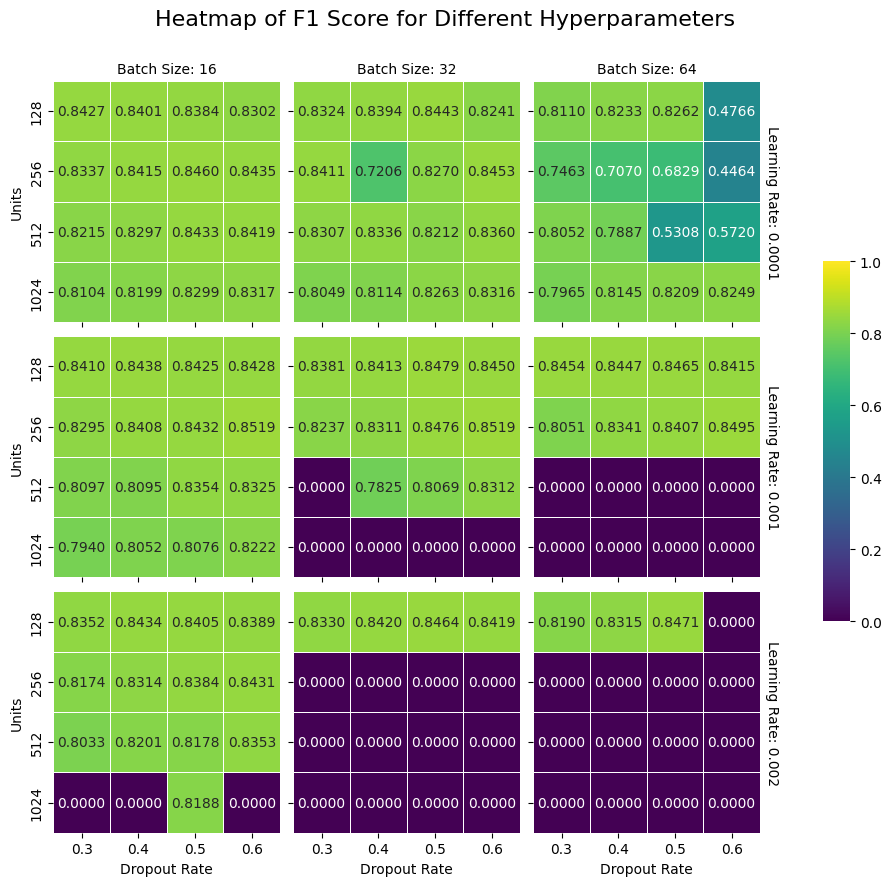

In [48]:
# Define the color scale limits
vmin, vmax = 0, 1

# Create a FacetGrid to visualize the impact of multiple hyperparameters
g = sns.FacetGrid(merged_df, col='Batch Size', row='Learning Rate', margin_titles=True, despine=False)

# Define the heatmap function
def heatmap(data, **kws):
    data = data.pivot_table(values='F1 Score', index='Units', columns='Dropout')
    sns.heatmap(data, **kws)

# Map the heatmap function to the grid
g.map_dataframe(heatmap, cmap='viridis', cbar_ax=g.fig.add_axes([.92, .3, .03, .4]), annot=True, fmt=".4f", linewidths=.5, vmin=vmin, vmax=vmax)

# Adjust the axis labels
g.set_axis_labels("Dropout Rate", "Units")
g.set_titles(col_template="Batch Size: {col_name}", row_template="Learning Rate: {row_name}")
g.fig.subplots_adjust(top=0.9, right=0.85)
g.fig.suptitle('Heatmap of F1 Score for Different Hyperparameters', fontsize=16)
plt.savefig('LSTM Hyperparameters Heatmap.png')
plt.show()


## Validation Threshold Testing

Given the models and hyperparameter tuning done, I would like to now focus on examining the precision and recall at the different threshold values. This will be evaluated on the validation data specifically, since it is technically a hyperparameter.

In [19]:
model_path = 'Models/EncDecLSTM/62sec_1layer_256units_0.6dropout_Adam_lr0.001_batch16.keras'
model = load_model(model_path)

In [20]:
val_data = (
    all_data[62]['encoder_input_data_val'],
    all_data[62]['decoder_input_data_val'],
    all_data[62]['decoder_target_data_val']
)
encoder_input_data_val, decoder_input_data_val, decoder_target_data_val = val_data

predictions = model.predict([encoder_input_data_val, decoder_input_data_val])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


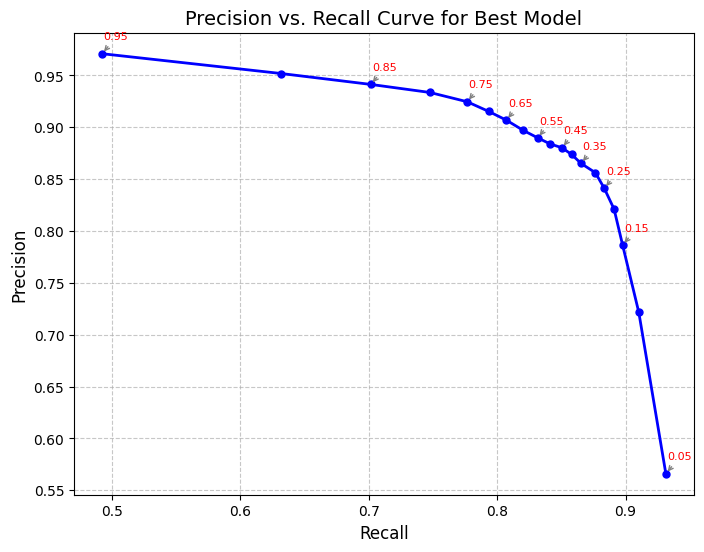

In [29]:
# Ensure consistent data shapes
y_true = decoder_target_data_val.flatten()
y_pred_prob = predictions.flatten()

def evaluate_threshold(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob >= threshold).astype(int)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    return precision, recall

# Threshold testing excluding 0 and 1, with larger increments
thresholds = np.arange(0.05, 1.0, 0.05)
precision_list = []
recall_list = []

for threshold in thresholds:
    precision, recall = evaluate_threshold(y_true, y_pred_prob, threshold)
    precision_list.append(precision)
    recall_list.append(recall)

# Plotting Precision vs. Recall with enhanced aesthetics
plt.figure(figsize=(8, 6))
plt.plot(recall_list, precision_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)

# Adding threshold annotations with arrows
for i, threshold in enumerate(thresholds):
    if i % 2 == 0:  # Annotate every other point to reduce clutter
        plt.annotate(
            f'{threshold:.2f}', 
            (recall_list[i], precision_list[i]), 
            textcoords="offset points", 
            xytext=(10,10), 
            ha='center',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='gray'),
            fontsize=8, color='red'
        )

# Customize plot
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision vs. Recall Curve for Best Model', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('Precision_vs_Recall_Curve_Enhanced.png', dpi=300)
plt.show()

## Generate Output

In [8]:
modelpath = 'Models/EncDecLSTM/62sec_1layer_256units_0.6dropout_Adam_lr0.001_batch16.keras'
model = load_model(modelpath)

In [9]:
# Function to generate prediction
def generate_prediction(model, input_seq, output_seq_length, output_features):
    # Create encoder model for prediction
    encoder_inputs = model.input[0]  # Encoder input from the trained model
    encoder_outputs, state_h_enc, state_c_enc = model.get_layer('encoder_lstm').output
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # Create decoder model for prediction
    decoder_inputs = model.input[1]  # Decoder input from the trained model
    decoder_state_input_h = Input(shape=(256,), name='decoder_state_input_h')
    decoder_state_input_c = Input(shape=(256,), name='decoder_state_input_c')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.get_layer('decoder_lstm')
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h_dec, state_c_dec]
    decoder_batch_norm = model.get_layer('decoder_batch_norm')
    decoder_outputs = decoder_batch_norm(decoder_outputs)
    decoder_dense = model.get_layer('decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)
    
    # Initialize target sequence with all zeros
    target_seq = np.zeros((1, 1, output_features))
    
    output_sequence = []

    # Generate sequence to complete the input sequence
    for _ in range(output_seq_length):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        output_sequence.append(output_tokens[0, -1, :])
        
        # Update states
        states_value = [h, c]
        
        # Update target sequence with the predicted step
        target_seq = np.zeros((1, 1, output_features))
        target_seq[0, 0, :] = output_tokens[0, -1, :]

    output_sequence = np.array(output_sequence)
    return np.vstack((input_seq.squeeze(), output_sequence.squeeze()))

In [54]:
# Function to re-include filtered notes
def restore_removed_notes(predicted_sequences, played_notes, total_notes=128):
    restored_sequences = []
    for sequence in predicted_sequences:
        restored_sequence = np.zeros((sequence.shape[0], total_notes))
        restored_sequence[:, played_notes] = sequence
        restored_sequences.append(restored_sequence)
    return np.array(restored_sequences)

In [55]:
# Function to convert piano roll to MIDI
def piano_roll_to_midi(piano_roll, fs=8, velocity=80, threshold=0.5):
    """Convert a Piano Roll array into a PrettyMIDI object with one instrument."""
    piano_roll = piano_roll.T
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    # pad 1 column of zeros so we can acknowledge changes at the first and last time step
    piano_roll = np.pad(piano_roll, ((0, 0), (1, 1)), 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        int_time = int(time)  # Ensure time is an integer
        if piano_roll[note, int_time + 1] > threshold:
            if prev_velocities[note] == 0:
                note_on_time[note] = time / fs  # Convert time to seconds
            prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time / fs)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0

    pm.instruments.append(instrument)
    return pm

In [56]:
def save_midi(path, midi_data):
    """ Save a PrettyMIDI object to a MIDI file.
        :param path: str, path to save the MIDI file
        :param midi_data: pretty_midi.PrettyMIDI, the MIDI data to save
    """
    midi_data.write(path)

In [57]:
# Function to build the LSTM model
def build_simple_lstm_model(input_features, output_features, latent_dim, dropout_rate=0.5, learning_rate=0.001):
    # Define encoder
    encoder_inputs = Input(shape=(None, input_features), name='encoder_inputs')
    encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_outputs = BatchNormalization(name='encoder_batch_norm')(encoder_outputs)
    encoder_outputs = Dropout(dropout_rate, name='encoder_dropout')(encoder_outputs)
    
    encoder_states = [state_h, state_c]
    
    # Define decoder
    decoder_inputs = Input(shape=(None, output_features), name='decoder_inputs')
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = BatchNormalization(name='decoder_batch_norm')(decoder_outputs)
    decoder_outputs = Dropout(dropout_rate, name='decoder_dropout')(decoder_outputs)
    
    decoder_dense = TimeDistributed(Dense(output_features, activation='sigmoid'), name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[Precision(), Recall()])

    return model

In [79]:
# Main function
def main(input_seq, true_output_seq, model_path, played_notes, threshold):
    input_features = input_seq.shape[2]
    output_features = true_output_seq.shape[1]
    output_seq_length = true_output_seq.shape[0]

    # Load the trained model
    model = build_simple_lstm_model(input_features, output_features, latent_dim=256)
    model.load_weights(model_path)

    # Generate output sequence
    output_seq = generate_prediction(model, input_seq, output_seq_length, output_features)
    print("Generated Output Shape:", output_seq.shape)

    # Re-include filtered notes for predicted sequence
    output_seq = restore_removed_notes([output_seq], played_notes)[0]
    
    # Re-include filtered notes for true output sequence
    true_output_seq_full = restore_removed_notes([np.vstack((input_seq.squeeze(), true_output_seq))], played_notes)[0]

    # Convert predicted output back to MIDI and save
    output_midi = piano_roll_to_midi(output_seq, fs=8, threshold=threshold)
    save_midi('predicted_output.mid', output_midi)
    print("Predicted output MIDI saved as 'predicted_output.mid'.")

    # Convert original output back to MIDI and save
    original_midi = piano_roll_to_midi(true_output_seq_full, fs=8, threshold=threshold)
    save_midi('original_output.mid', original_midi)
    print("Original output MIDI saved as 'original_output.mid'.")

# Example usage
sample_index = 11  # Change this to select a different sample
input_seq = all_data[62]['encoder_input_data_test'][sample_index:sample_index+1]  # Test input sequence
true_output_seq = all_data[62]['decoder_target_data_test'][sample_index]  # True output sequence
played_notes = all_data[62]['played_notes']

model_path = 'Models/EncDecLSTM/62sec_1layer_256units_0.6dropout_Adam_lr0.001_batch16.keras'
main(input_seq, true_output_seq, model_path, played_notes, threshold=0.85)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Generated Output Shape: (64, 82)
Predicted output MIDI saved as 'predicted_output.mid'.
Original output MIDI saved as 'original_output.mid'.


## Precision and Recall Over Time

In [10]:
model_path = 'Models/EncDecLSTM/62sec_1layer_256units_0.6dropout_Adam_lr0.001_batch16.keras'
model = load_model(model_path)

In [11]:
def calculate_precision_recall_over_time(true_sequences, predicted_sequences, threshold=0.5):
    precisions = []
    recalls = []

    # Iterate over each timestep
    for t in range(true_sequences.shape[1]):
        true_timestep = true_sequences[:, t, :]
        predicted_timestep = (predicted_sequences[:, t, :] > threshold).astype(int)
        
        precision = precision_score(true_timestep.reshape(-1), predicted_timestep.reshape(-1), average='binary', zero_division=0)
        recall = recall_score(true_timestep.reshape(-1), predicted_timestep.reshape(-1), average='binary', zero_division=0)

        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


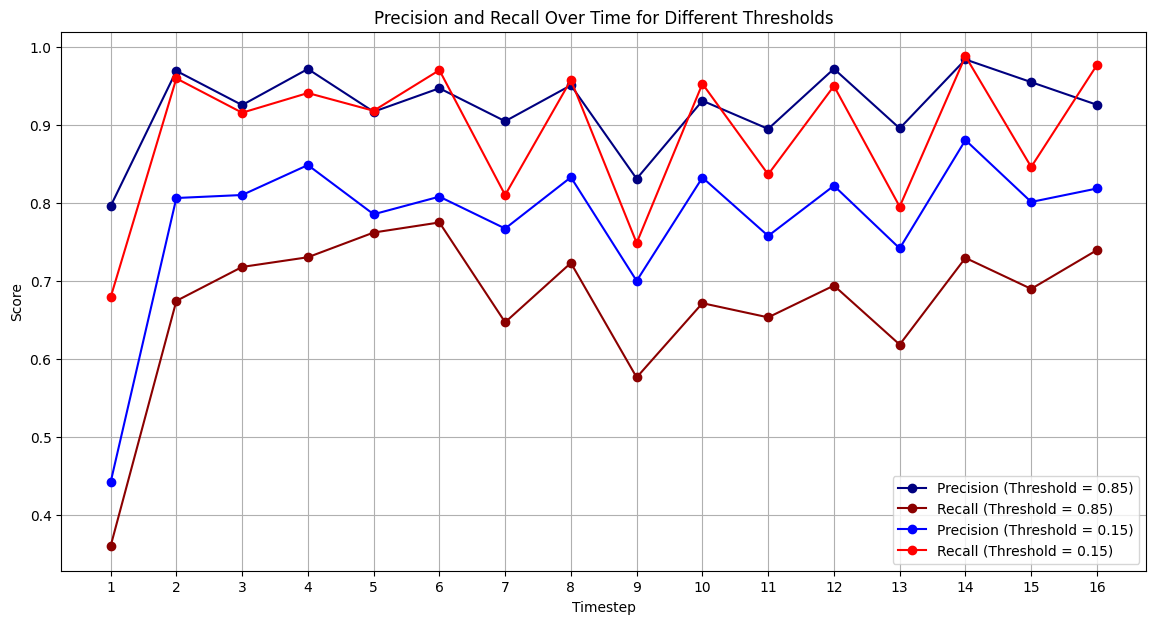

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import numpy as np
from keras.models import load_model

# Function to calculate precision and recall over time
def calculate_precision_recall_over_time(true_sequences, predicted_sequences, threshold=0.5):
    precisions = []
    recalls = []

    # Iterate over each timestep
    for t in range(true_sequences.shape[1]):
        true_timestep = true_sequences[:, t, :]
        predicted_timestep = (predicted_sequences[:, t, :] > threshold).astype(int)
        
        precision = precision_score(true_timestep.reshape(-1), predicted_timestep.reshape(-1), average='binary', zero_division=0)
        recall = recall_score(true_timestep.reshape(-1), predicted_timestep.reshape(-1), average='binary', zero_division=0)

        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls

# Load the model
model_path = 'Models/EncDecLSTM/62sec_1layer_256units_0.6dropout_Adam_lr0.001_batch16.keras'
model = load_model(model_path)

# Predict the output sequences for the test set
encoder_input_data_test = all_data[62]['encoder_input_data_test']
decoder_input_data_test = all_data[62]['decoder_input_data_test']
decoder_target_data_test = all_data[62]['decoder_target_data_test']

predictions = model.predict([encoder_input_data_test, decoder_input_data_test])

# Calculate precision and recall over time for both thresholds
thresholds = [0.85, 0.15]
avg_precisions_075, avg_recalls_075 = calculate_precision_recall_over_time(decoder_target_data_test, predictions, threshold=thresholds[0])
avg_precisions_025, avg_recalls_025 = calculate_precision_recall_over_time(decoder_target_data_test, predictions, threshold=thresholds[1])

# Plot the results
plt.figure(figsize=(14, 7))

# Plot for threshold 0.85
plt.plot(range(1, len(avg_precisions_075) + 1), avg_precisions_075, label='Precision (Threshold = 0.85)', marker='o', color='navy')
plt.plot(range(1, len(avg_recalls_075) + 1), avg_recalls_075, label='Recall (Threshold = 0.85)', marker='o', color='darkred')

# Plot for threshold 0.15
plt.plot(range(1, len(avg_precisions_025) + 1), avg_precisions_025, label='Precision (Threshold = 0.15)', marker='o', color='blue')
plt.plot(range(1, len(avg_recalls_025) + 1), avg_recalls_025, label='Recall (Threshold = 0.15)', marker='o', color='red')

plt.xticks(range(1, len(avg_precisions_075) + 1))
plt.xlabel('Timestep')
plt.ylabel('Score')
plt.title('Precision and Recall Over Time for Different Thresholds')
plt.legend()
plt.grid(True)
plt.savefig('PrecisionRecallOverTime_Thresholds_075_025.png')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


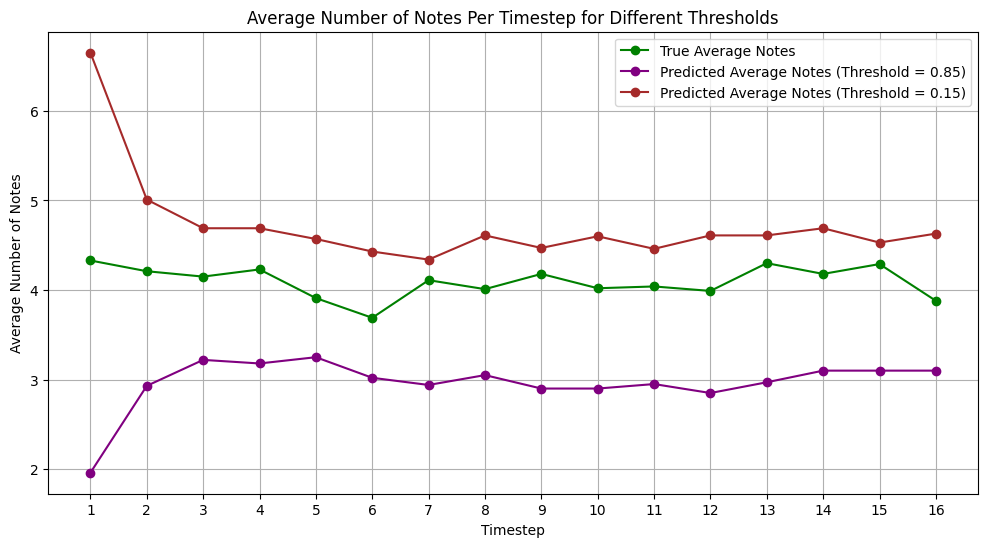

In [15]:
def calculate_avg_notes_per_timestep(sequences):
    """ Calculate the average number of notes per timestep. """
    return np.mean(np.sum(sequences, axis=-1), axis=0)

def apply_threshold(sequences, threshold):
    """ Apply threshold to the predicted sequences. """
    return (sequences > threshold).astype(int)

# Load the model
model_path = 'Models/EncDecLSTM/62sec_1layer_256units_0.6dropout_Adam_lr0.001_batch16.keras'
model = load_model(model_path)

# Predict the output sequences for the test set
encoder_input_data_test = all_data[62]['encoder_input_data_test']
decoder_input_data_test = all_data[62]['decoder_input_data_test']
decoder_target_data_test = all_data[62]['decoder_target_data_test']

predictions = model.predict([encoder_input_data_test, decoder_input_data_test])

# Apply thresholds to the predictions
thresholds = [0.85, 0.15]
predictions_thresholded_075 = apply_threshold(predictions, thresholds[0])
predictions_thresholded_025 = apply_threshold(predictions, thresholds[1])

# Calculate average number of notes per timestep for true and predicted sequences
avg_notes_true = calculate_avg_notes_per_timestep(decoder_target_data_test)
avg_notes_pred_075 = calculate_avg_notes_per_timestep(predictions_thresholded_075)
avg_notes_pred_025 = calculate_avg_notes_per_timestep(predictions_thresholded_025)

# Plot the results
plt.figure(figsize=(12, 6))
timesteps = range(1, len(avg_notes_true) + 1)
plt.plot(timesteps, avg_notes_true, label='True Average Notes', marker='o', color='green')
plt.plot(timesteps, avg_notes_pred_075, label='Predicted Average Notes (Threshold = 0.85)', marker='o', color='purple')
plt.plot(timesteps, avg_notes_pred_025, label='Predicted Average Notes (Threshold = 0.15)', marker='o', color='brown')
plt.xticks(timesteps)  # Set x-ticks to 1 through the number of timesteps
plt.xlabel('Timestep')
plt.ylabel('Average Number of Notes')
plt.title('Average Number of Notes Per Timestep for Different Thresholds')
plt.legend()
plt.grid(True)
plt.savefig('AvgNotesPlayedatThresholds_075_025.png')
plt.show()


## Convolutional LSTM

In [8]:
def build_conv_lstm_model(input_shape, output_shape, filters=64, kernel_size=(3, 3), dropout_rate=0.5, learning_rate=0.001):
    # Define encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_conv_lstm = ConvLSTM2D(filters=filters, kernel_size=kernel_size, return_state=True, return_sequences=True, padding='same')
    encoder_outputs, state_h, state_c = encoder_conv_lstm(encoder_inputs)
    encoder_outputs = BatchNormalization()(encoder_outputs)
    encoder_outputs = Dropout(dropout_rate)(encoder_outputs)
    
    encoder_states = [state_h, state_c]
    
    # Define decoder
    decoder_inputs = Input(shape=output_shape)
    decoder_conv_lstm = ConvLSTM2D(filters=filters, kernel_size=kernel_size, return_sequences=True, return_state=True, padding='same')
    decoder_outputs, _, _ = decoder_conv_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = BatchNormalization()(decoder_outputs)
    decoder_outputs = Dropout(dropout_rate)(decoder_outputs)
    
    decoder_dense = TimeDistributed(Dense(output_shape[-1], activation='sigmoid'))
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[Precision(), Recall()])
    
    return model

def train_conv_lstm_model(model, train_data, val_data, model_name, epochs=50, batch_size=32):
    encoder_input_data_train, decoder_input_data_train, decoder_target_data_train = train_data
    encoder_input_data_val, decoder_input_data_val, decoder_target_data_val = val_data
    
    checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    csv_logger = CSVLogger(f'{model_name}_log.csv', append=True, separator=',')
    
    history = model.fit(
        [encoder_input_data_train, decoder_input_data_train], decoder_target_data_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=([encoder_input_data_val, decoder_input_data_val], decoder_target_data_val),
        callbacks=[checkpoint, early_stopping, csv_logger]
    )

    epochs_taken = len(history.history['loss'])
    
    return epochs_taken, history

def evaluate_lstm_model(model, data):
    encoder_input_data, decoder_input_data, decoder_target_data = data
    results = model.evaluate([encoder_input_data, decoder_input_data], decoder_target_data)
    return results

In [38]:
filters_list = [64, 128]
kernel_sizes = [(3, 3)]
dropout_rates = [0.5]
learning_rates = [0.001]
batch_sizes = [16]


sequence_length = 62  # Example sequence length
train_data = (
    all_data[sequence_length]['encoder_input_data_train'].reshape((-1, 48, 82, 1, 1)),  # Add time steps and channel dimensions
    all_data[sequence_length]['decoder_input_data_train'].reshape((-1, 16, 82, 1, 1)),  # Add time steps and channel dimensions
    all_data[sequence_length]['decoder_target_data_train'].reshape((-1, 16, 82, 1))  # Add time steps and channel dimensions
)
val_data = (
    all_data[sequence_length]['encoder_input_data_val'].reshape((-1, 48, 82, 1, 1)),  # Add time steps and channel dimensions
    all_data[sequence_length]['decoder_input_data_val'].reshape((-1, 16, 82, 1, 1)),  # Add time steps and channel dimensions
    all_data[sequence_length]['decoder_target_data_val'].reshape((-1, 16, 82, 1))  # Add time steps and channel dimensions
)
test_data = (
    all_data[sequence_length]['encoder_input_data_test'].reshape((-1, 48, 82, 1, 1)),  # Add time steps and channel dimensions
    all_data[sequence_length]['decoder_input_data_test'].reshape((-1, 16, 82, 1, 1)),  # Add time steps and channel dimensions
    all_data[sequence_length]['decoder_target_data_test'].reshape((-1, 16, 82, 1))  # Add time steps and channel dimensions
)
input_shape = (48, 82, 1, 1)  # Update input shape with time steps and channel dimension
output_shape = (16, 82, 1, 1)  # Update output shape with time steps and channel dimension

# Check the shapes of the training data
print("Shape of encoder_input_data_train:", train_data[0].shape)
print("Shape of decoder_input_data_train:", train_data[1].shape)
print("Shape of decoder_target_data_train:", train_data[2].shape)
print("Input shape for ConvLSTM model:", input_shape)
print("Output shape for ConvLSTM model:", output_shape)

all_results = []

results_path = 'conv_lstm_hyperparameter_tuning_results2.csv'
with open(results_path, 'w') as f:
    f.write('Model,Filters,Kernel Size 1,Kernel Size 2,Dropout Rate,Learning Rate,Batch Size,Epochs Taken,Train Loss,Train Precision,Train Recall,Val Loss,Val Precision,Val Recall,Test Precision,Test Recall\n')


for filters in filters_list:
    for kernel_size in kernel_sizes:
        for dropout_rate in dropout_rates:
            for learning_rate in learning_rates:
                for batch_size in batch_sizes:
                    
                    model_name = f'conv_lstm_{filters}filters_{kernel_size[0]}x{kernel_size[1]}kernel_{dropout_rate}dropout_{learning_rate}lr_{batch_size}batch'
                    print(f'Training model: {model_name}')
                    
                    model = build_conv_lstm_model(input_shape, output_shape, filters, kernel_size, dropout_rate, learning_rate)
                    epochs_taken, history = train_conv_lstm_model(model, train_data, val_data, model_name, epochs=500, batch_size=batch_size)
                    
                    train_results = evaluate_lstm_model(model, train_data)
                    val_results = evaluate_lstm_model(model, val_data)
                    test_results = evaluate_lstm_model(model, test_data)  # Evaluate on test data
                    
                    # Append the results incrementally to the CSV file
                    with open(results_path, 'a') as f:
                        f.write(f'{model_name},{filters},{kernel_size[0]},{kernel_size[1]},{dropout_rate},{learning_rate},{batch_size},{epochs_taken},{train_results[0]},{train_results[1]},{train_results[2]},{val_results[0]},{val_results[1]},{val_results[2]},{test_results[1]},{test_results[2]}\n')
                    
                    # Clear session to free up memory
                    K.clear_session()

# Save all results to a CSV file
results_df = pd.read_csv(results_path)
print(results_df)

Shape of encoder_input_data_train: (464, 48, 82, 1, 1)
Shape of decoder_input_data_train: (464, 16, 82, 1, 1)
Shape of decoder_target_data_train: (464, 16, 82, 1)
Input shape for ConvLSTM model: (48, 82, 1, 1)
Output shape for ConvLSTM model: (16, 82, 1, 1)
Training model: conv_lstm_64filters_3x3kernel_0.5dropout_0.003lr_16batch_1x1strides
Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.5214 - precision: 0.2639 - recall: 0.7680
Epoch 1: val_loss improved from inf to 0.31456, saving model to conv_lstm_64filters_3x3kernel_0.5dropout_0.003lr_16batch_1x1strides.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step - loss: 0.5171 - precision: 0.2681 - recall: 0.7694 - val_loss: 0.3146 - val_precision: 0.8023 - val_recall: 0.5853
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - loss: 0.1858 - precision: 0.7252 - recall: 0.7453
Epoch 2: val_loss improved from 0.31456 to 0.17541, saving model to conv_lstm_64filters_3x3kernel_0.5dropout_0.003lr_16batch_1x1strides.keras
29/29 ━━━━

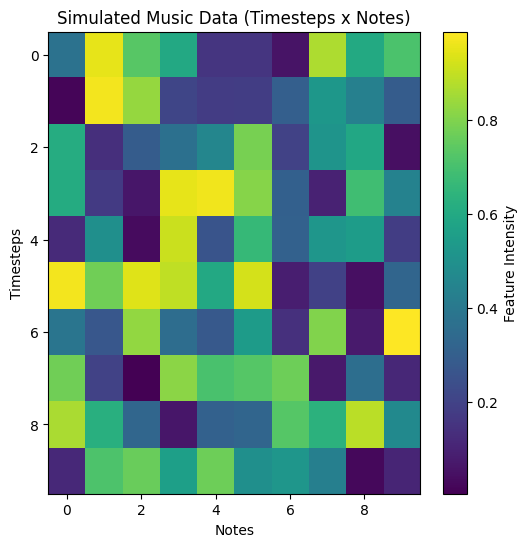

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data with 10 timesteps and 10 notes
timesteps = 10
notes = 10
features_per_note = 1  # Single feature per note

# Generate random data for visualization
data = np.random.rand(timesteps, notes, features_per_note).squeeze()

# Plot the simulated data
plt.figure(figsize=(6, 6))
plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='Feature Intensity')
plt.xlabel('Notes')
plt.ylabel('Timesteps')
plt.title('Simulated Music Data (Timesteps x Notes)')
plt.show()

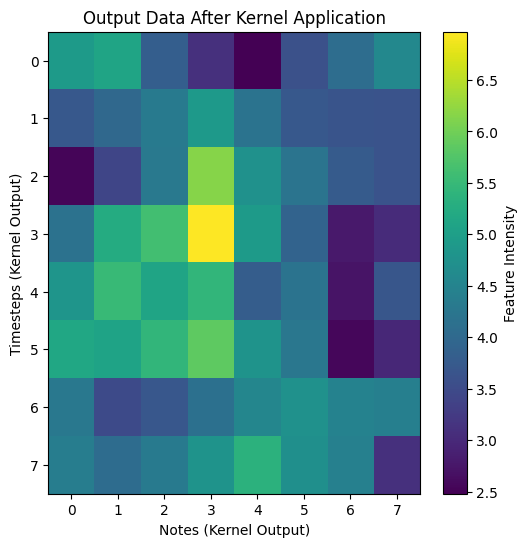

In [16]:
# Define kernel size
kernel_size = (3, 3)

# Function to apply kernel and visualize
def apply_kernel(data, kernel_size):
    timesteps, notes = data.shape
    kt, kn = kernel_size
    output = np.zeros((timesteps - kt + 1, notes - kn + 1))
    
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            block = data[i:i+kt, j:j+kn]
            output[i, j] = np.sum(block)  # Simplified kernel operation (sum of block)
    
    return output

# Apply kernel
output_data = apply_kernel(data, kernel_size)

# Plot the output data
plt.figure(figsize=(6, 6))
plt.imshow(output_data, aspect='auto', cmap='viridis')
plt.colorbar(label='Feature Intensity')
plt.xlabel('Notes (Kernel Output)')
plt.ylabel('Timesteps (Kernel Output)')
plt.title('Output Data After Kernel Application')
plt.show()
